In [3]:
import os

# from google.colab import drive
# drive.mount('/content/drive/')
os.chdir('..')
# os.chdir('/content/drive/MyDrive/Times-Series-Library/')
os.getcwd()

'C:\\Users\\BubbleTea\\Desktop\\Energy Forcasting\\Time-Series-Library'

In [ ]:
!pip install -r requirements.txt

# Training

Train a new model:

In [ ]:
!python -u run.py --train --model_id new_model --run_id new_run --no-neptune

Training might take too long on Colab without GPU, add `--debug` to see the 'mock' training result on a mini subset:

In [12]:
!python -u run.py --train --model_id new_model --run_id new_run_1 --no-neptune --debug

New model loaded on cpu
val/test_len: 73 | train_len: 223
>>>>>>>>>>>>>>>training : model_new_model_run_new_run_1@iter0>>>>>>>>>>>>>>>
Epoch: 0 | validating... | 00:00:33
Epoch: 0 | Train Loss: 1.4187353, Vali Loss: 1.3201882, Test Loss: 1.1025535 | 00:02:13
Epoch: 0 | Validation loss decreased (inf --> 1.320188). Saving model ...
Epoch: 1 | validating... | 00:00:27
Epoch: 1 | Train Loss: 1.2127151, Vali Loss: 1.1620841, Test Loss: 0.9611840 | 00:02:06
Epoch: 1 | Validation loss decreased (1.320188 --> 1.162084). Saving model ...
Epoch: 2 | validating... | 00:00:27
Epoch: 2 | Train Loss: 1.0815762, Vali Loss: 1.0273634, Test Loss: 0.8526125 | 00:02:07
Epoch: 2 | Validation loss decreased (1.162084 --> 1.027363). Saving model ...
Epoch: 3 | validating... | 00:00:25
Epoch: 3 | Train Loss: 0.9504391, Vali Loss: 0.9128584, Test Loss: 0.7800351 | 00:02:02
Epoch: 3 | Validation loss decreased (1.027363 --> 0.912858). Saving model ...
Epoch: 4 | validating... | 00:00:29
Epoch: 4 | Train Loss:

# Testing


Model will be tested after completing training, generating results in the folder:

\results\model_`$model_id$`_run_`$run_id$`@iter0

- model checkpoints are stored in `\checkpoints\`
- testing results, listed as follow, are stored in `\test\`

| file          | description                                                |
| ------------- | ---------------------------------------------------------- |
| result_0.pdf  | plot of testing result with normalized data                |
| result_1.pdf  | plot of testing result with de-normalized data             |
| result_df.csv | stored the prediction and the target values, date as index |
| metrics.json  | stored the testing metrics                                 |


You can always re-test a trained model, but notice that the previous testing results will be overwritten.

E.g., The testing result of the pre-trained model with model_id = `ID1` and run_id = `000` is already saved in \results\model_ID1_run_000@iter0\

See the re-test result of the just trained 'debug' model:

In [ ]:
!python -u run.py --no-train --model_id new_model --run_id new_run_1 --no-neptune --debug

# Continue Training

The trained model can be trained again with same (not recommended) / different dataset

The new data should be pre-processed as in `Data Prepocessing.ipynb` and generate the new CSV file, e.g., `/new_dataset/power_2.csv'

In [ ]:
!python -u run.py --train --model_id ID1 --run_id 000 --no-neptune --data_path /new_dataset/power_2.csv

To optimize the training result, it is recommended to append the most recent 120 (`seq_len + gap_len`) records from the previous dataset (power.csv) to the beginning of the new dataset, thereby adding 116 (`seq_len`) additional data samples for this new dataset.

# Inference

In [4]:
import json
import pandas as pd

from Experiment.ExpPowerForecasting import inference

# prepare historical power output
with open('./dataset/generation.json') as f:
    target = json.load(f)
target = pd.DataFrame.from_dict(target, orient='index')
target.index = pd.to_datetime(target.index)

# set the start timestamp for inference, here we use the next hour of the last timestamp
# in the historical power output as the start time
start = (target.index[-1] + pd.DateOffset(hours=1)).replace(minute=0)

# set the frequency for inference, here we use 1 minute
freq = '1min'

# set the time range for inference, length of which must be a multiple of seq_len (12)
# here we are trying to predict for the next hour (60 * 1min)
y_time = pd.period_range(start=start, periods=5 * 12, freq=freq).to_timestamp()

# prepare temperature data, the most recent entry must be later than all timestamps in y_time.
temperature_df = pd.read_csv('./dataset/temperature_all.csv', index_col=0).loc[:, ['B']]
temperature_df.index = pd.to_datetime(temperature_df.index)

# use linear interpolation to down-sample temperature data to 1 minute frequency
temperature_df = temperature_df.resample(freq).interpolate(method='time', order=1)

# since the new temperature data is not available, here I simply make up the data by copying the last entries
temperature_df = temperature_df.reindex(temperature_df.index.union(y_time))
temperature_df.loc[y_time, :] = temperature_df.iloc[-2 * len(y_time):-len(y_time), :].values

# set up the experiment and predict
exp = inference(model_id='ID1', run_id='003')

# the result should be precise to 1 minute, as specified by the freq
result_series = exp.predict(y_time=y_time, temperature_df=temperature_df, power_output=target)

# to obtain the average forecasted output for each successive 30 minute interval:
avrg_result_30min = result_series.resample('30min').mean()

Trained model loaded on cuda
Previous checkpoint: checkpoint_0.pth
Using data ['B', 'target']
val/test_len: 30924 | train_len: 92773
predict time: 00:00:11



(2022-06-01 00:00:00    54.665581
 2022-06-01 00:30:00    27.850624
 Freq: 30T, Name: prediction, dtype: float32,
 <Axes: >)

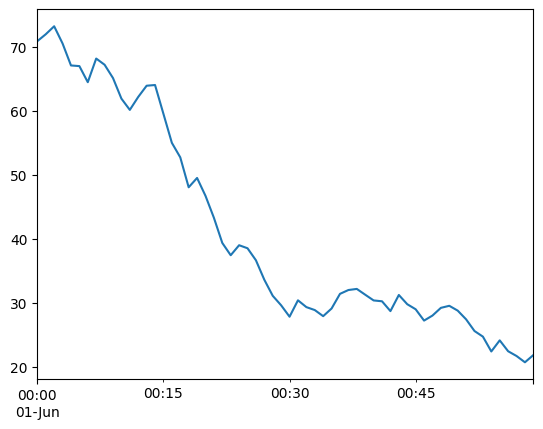

In [5]:
avrg_result_30min, result_series.plot()